# Validating generator performance notebook (synthetic, conditional case).

## Z Issa Feb 2023

In this notebook, we evaluate the output of the conditional NSDE generator 

$$G_\theta: C([t, T]; \mathbb{R}^w) \times C([0, t]; \mathbb{R}^d) \to C([t, T]; \mathbb{R}^d),$$


where the action of the generator is given by the solution to the conditional neural SDE 

\begin{align*}
    dX_t &= \mu_\theta(t, X_t, c)dt + \sigma_\theta(t, X_t, c) \circ dW_t, \\ 
    X_0 &= \xi_\theta(h_0, c), \\
    Y_t &= \pi_\theta(X_t, c),
\end{align*}

where $\mu_\theta: \mathbb{R}^{x + 1} \times \mathbb{R}^C \to \mathbb{R}^{x}, \sigma_\theta: \mathbb{R}^{x+1}\times \mathbb{R}^{C} \to \mathbb{R}^{x \times w}, \xi_\theta : \mathbb{R}^v \times \mathbb{R}^C \to \mathbb{R}^x$ and $\pi_\theta: \mathbb{R}^x \times \mathbb{R}^C \to \mathbb{R}^d$ are the neural networks governing the dynamics of the SDE, $x, d, w, v \in \mathbb{N}$ are sizes of the hidden state, output state, noise dimension and initial noise distribution respectively, and $C$ is the size of the conditioning vector. 

Here, we validate the performance of the test outlined in Section 10.4 of the paper ``Training Neural SDEs as MMD-GANs via the signature kernel''. 

In [ ]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import sigkernel
import torch
import torch.optim.swa_utils as swa_utils
from matplotlib.ticker import FuncFormatter
from src.utils.transformations import Transformer
from tqdm.notebook import tqdm
import scienceplots

from src.gan.base import get_real_data
from src.gan.generators import PathConditionalSigGenerator
from src.utils.helper_functions.data_helper_functions import subtract_initial_point, get_scalings, process_generator, \
    normalize, inv_normalize
from src.utils.helper_functions.global_helper_functions import get_project_root
from src.utils.helper_functions.plot_helper_functions import make_grid

plt.style.use("science")
plt.rcParams['axes.titlesize']  = 24
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize']  = 22

In [4]:
torch.manual_seed(0)

## 0. Configurations

We put here the configurations used to train the generator. If you have used a different configuration, you will need to change the required fields here.

In [5]:
is_cuda = torch.cuda.is_available()
device = 'cuda' if is_cuda else 'cpu'

if not is_cuda:
    print("Warning: CUDA not available; falling back to CPU but this is likely to be very slow.")
    
# You realistially need GPU access (either natively or via cloud computing) to run this notebook.

In [6]:
# Data arguments
## Data hyperparameters
output_dim          = 1                     # Dimension of the outputs.
batch_size          = 128                   # Size of minibatches when training.
path_length         = 48                    # Number of timesteps in paths.
dataset_size        = 4*8192                # Number of paths in the train/test datasets.
normalisation       = None                  # How to transform paths. Options are None, "mean_var", "min_max"
scale               = 1e0                   # Float scale to each path dimension.
time_add_type       = "basic"               # Controls how time is accounted for. "basic" -> 0, 1, 2..., "realistic" -> real
drift_values          = [0.1, 0.0, -0.1]     # mu0, mu1, mu2 for synthetic example
diffusion_values      = [0.2, 0.2, 0.2]      # sig0, sig1, sig2 for synthetic example
process_type          = "bm"                 # "gbm" or "bm"
syn2_mask_type        = "qv"                 # "tv" or "qv" (total or quadratic variation)
dt                    = 1                    # Timestep size
S0                    = 0.                   # Starting valuetimes.

## Data generation / dataset arguments
data_type             = "syn_type2"                  # "syn_type1", "syn_type2", "forex"
change_pt             = int(2*path_length/3)         # When to split paths into conditional/resolvant pairs
cond_length           = change_pt                    # Length of conditioning paths
eval_length           = int(path_length - change_pt) # Length of conditioned paths

generator_config = {
    "noise_size"         : 8,                 # How many dimensions the Brownian motion has.
    "hidden_size"        : 16,                # How big the hidden state of the generator SDE is.
    "mlp_size"           : 32,                # How big the layers in the various MLPs are.
    "num_layers"         : 3,                 # How many hidden layers to have in the various MLPs.
    "activation"         : "LipSwish",        # Activation function to use
    "tanh"               : True,              # Whether to apply final tanh activation
    "tscale"             : 1,                 # Clip parameter for tanh, i.e. [-1, 1] to [-c, c]
    "fixed"              : True,              # Whether to fix the starting point or not
    "noise_type"         : "general",         # Noise type argument for torchsde
    "sde_type"           : "stratonovich",    # SDE integration type from torchsde
    "dt_scale"           : 1e0,               # Grid shrinking parameter
    "integration_method" : "reversible_heun"  # Integration method for torchsde
}

do_transforms = True

cond_transformations     = OrderedDict([
    ("visibility"        , False), 
    ("time_difference"   , False), 
    ("time_normalisation", True), 
    ("lead_lag"          , True), 
    ("basepoint"         , False)
])

cond_transformation_args = OrderedDict([
    ("visibility"        , {}), 
    ("time_difference"   , {}), 
    ("time_normalisation", {}), 
    ("lead_lag"          , {"time_in": True, "time_out": False, "time_normalisation": False}), 
    ("basepoint"         , {})
])

out_transformations     = OrderedDict([
    ("visibility"        , False), 
    ("time_difference"   , False), 
    ("time_normalisation", True), 
    ("lead_lag"          , False), 
    ("basepoint"         , False)
])

out_transformation_args = OrderedDict([
    ("visibility"        , {}), 
    ("time_difference"   , {}), 
    ("time_normalisation", {}), 
    ("lead_lag"          , {"time_in": True, "time_out": False, "time_normalisation": False}), 
    ("basepoint"         , {})
])

subtract_start = True

## Conditional arguments

emp_size         = 32           # Size of empirical measure made by generator
conditional_type = "signature"  # Can be either "cde" or "signature"

conditional_config = {
    "logsig"          : True,        # Use logsignature in conditional generator
    "order"           : 4,           # Order of signature to take 
    "cde_hidden_size" : 16,          # How big the hidden state evolution is for the CDE solver
    "cde_mlp_size"    : 16,          # How many neurons in the vector field layers for the CDE
    "cde_num_layers"  : 3,           # How many layers in the nns defining the vector fields of the CDE
    "cde_activation"  : "LipSwish",  # Activation function applied to each layer
    "cde_tanh"        : True,        # Whether to use tanh smoothing
    "cde_dt_scale"    : 1e0          # Integrator mesh scaler
}

cond_transformer   = Transformer(cond_transformations, cond_transformation_args, device).to(device) if do_transforms else lambda x: x
out_transformer    = Transformer(out_transformations, out_transformation_args, device).to(device) if do_transforms else lambda x: x

## 1. Create testing data. 

We build testing data in the same way we built the training data: we choose an inflextion point $t \in [0, T]$, and change the parameters of the data generator according to the quadratic variation of the conditioning paths over $[0, t]$.

In [7]:
if time_add_type == "basic":
    times = np.linspace(0, path_length-1, path_length)
else:
    times = np.linspace(0, path_length*dt, path_length)

np_data         = np.zeros((dataset_size, path_length, int(1 + output_dim)))
np_data[..., 0] = np.tile(times, (dataset_size, 1))

mu0, mu1, mu2    = drift_values
sig0, sig1, sig2 = diffusion_values

## gbm -> gbm_{1, 2, 3}

np_data[:, :cond_length, 1:] = np.expand_dims(process_generator(
    dataset_size, cond_length-1, cond_length, mu1, sig1, S0, proc=process_type
), axis=-1)

S0_ = np_data[:, cond_length-1, 1]

# Non-Markovian example
mfunc = lambda x: np.power(x, 2) if syn2_mask_type == "qv" else np.abs(x)

nm_condition       = np.sum(mfunc(np.diff(np_data[:, :cond_length, 1], axis=1)), axis=1)
quantiles          = np.quantile(nm_condition, [0.33, 0.66])

mask0 = nm_condition <= quantiles[0]
mask1 = (nm_condition <= quantiles[1])*(nm_condition > quantiles[0])
mask2 = nm_condition > quantiles[1]

for i in range(3):
    this_mask = eval(f"mask{i}")
    this_mu   = eval(f"mu{i}")
    this_sig  = eval(f"sig{i}")

    np_data[this_mask, cond_length-1:, 1:] = np.expand_dims(process_generator(
        sum(this_mask), eval_length, eval_length+1, this_mu, this_sig, S0_[this_mask], proc=process_type
    ), axis=-1)
    
(tpast, ts), data_size, train_dataloader = get_real_data(
    np_data, batch_size, dataset_size, device, time_add_type, time_add_round=4, filter_by_time=True,
    split=change_pt, normalisation=normalisation, scale=scale
)

infinite_train_dataloader = (elem for it in iter(lambda: train_dataloader, None) for elem in it)

## 2. Load conditional generator. 

We now load the trained conditional generator. 

In [8]:
gen_fp  = get_project_root().as_posix() + f"/saved_models/generators/{data_type}/"

generator_state_dict     = torch.load(gen_fp + "path_cond_generator.pkl")
averaged_generator_state_dict     = torch.load(gen_fp + "_path_cond_generator_averaged.pkl")

conditioning_dim = data_size

if cond_transformations["lead_lag"]:
    if cond_transformation_args["lead_lag"]["time_out"]:
        conditioning_dim += 1

extra_config = {k: conditional_config[k] for k in ("logsig", "order")}
total_config = {**generator_config, **extra_config, **{"conditioning_dim" : conditioning_dim}}

generator    = PathConditionalSigGenerator(data_size=data_size, **total_config).to(device)
averaged_generator     = swa_utils.AveragedModel(generator)
generator.load_state_dict(generator_state_dict)
averaged_generator.load_state_dict(averaged_generator_state_dict)

<All keys matched successfully>

## 3. Sample path plots 

We provide some example plots of distributions obtained from the conditional generator.

Text(0.5, 1.0, 'Conditional generation, class 1')

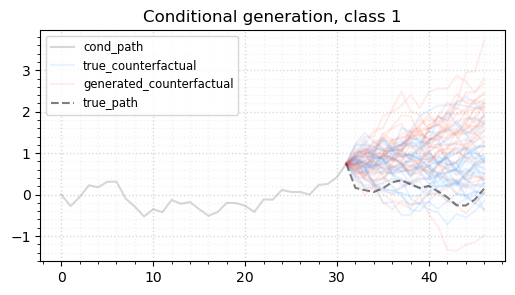

In [9]:
## Synthetic example
cond_samples, true_samples = next(infinite_train_dataloader)

n_evaluation_samples = 1
num_eval_paths       = 32

# 1. Subsample from the conditioning paths and construct true distributions
eval_indexes    = torch.randperm(batch_size)[:n_evaluation_samples]
eval_cond_paths = cond_samples[eval_indexes].detach().cpu()/scale
eval_true_paths = true_samples[eval_indexes].detach().cpu()/scale

# 2. Un-normalise (as class tagging was done on the un-normalized paths)
if normalisation is not None:
    val1, val2 = get_scalings(np_data[..., 1:], normalisation)
    val1 = torch.tensor(val1)
    val2 = torch.tensor(val2)

    norm_cond_paths = inv_normalize(eval_cond_paths, normalisation, val1=val1, val2=val2)
    norm_true_paths = inv_normalize(eval_true_paths, normalisation, val1=val1, val2=val2)
else:
    norm_cond_paths = eval_cond_paths
    norm_true_paths = eval_true_paths

# 3. Loop over conditional samples and plot distributions against true
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
make_grid(axis=ax)

ts_cond = tpast.cpu()
ts_true = ts.cpu() - 1

gen_first  = True
cf_first   = True
cond_first = True
true_first = True

for cp, tp in zip(eval_cond_paths, eval_true_paths):
    # Check what class this path belongs to
    nm_val = mfunc(np.diff(cp[:, 1])).sum()
    if nm_val < quantiles[0]:
        class_ = 0
    elif (nm_val >= quantiles[0]) and (nm_val < quantiles[1]):
        class_ = 1
    else:
        class_ = 2

    # Generate bank of counterfactuals
    this_mu, this_sig = eval(f"mu{int(class_)}"), eval(f"sig{int(class_)}")
    this_S0           = torch.tile(cp[-1, 1], (num_eval_paths, 1)).flatten().cpu().numpy()

    this_mu  = np.array(this_mu)
    this_sig = np.array(this_sig)
    cfs      = process_generator(num_eval_paths, eval_length, eval_length, this_mu, this_sig, this_S0, proc=process_type)

    # Generate a counterfactual
    cp_t = torch.clone(cp)
    cp_t[..., 1] = cp[..., 1] * scale
    cp_t = cond_transformer(cp.unsqueeze(0))

    if subtract_initial_point:
        cp_t = subtract_initial_point(cp_t)

    #cp_t_t = torch.tile(cp_t, (num_eval_paths, 1, 1))
    gen_cfs = generator(ts, cp_t, num_eval_paths)[0].cpu()

    if normalisation is not None:
        gen_cfs = inv_normalize(gen_cfs, normalisation, val1=val1, val2=val2)

    if subtract_initial_point:
        gen_cfs = subtract_initial_point(gen_cfs)
        tp = tp[:, 1] - tp[0, 1]
        plot_gen_cfs = gen_cfs[..., 1].detach().cpu().numpy() + cp[-1, 1].item()
        tp = tp + cp[-1, 1].item()

    plot_cond    = cp[..., 1].cpu()

    # Plot the results
    label = "cond_path" if cond_first else ""
    ax.plot(ts_cond, plot_cond, color="slategrey", alpha=0.3, label=label)
    cond_first = False
    for cfp in cfs:
        label = "true_counterfactual" if cf_first else ""
        ax.plot(ts_true, cfp, color="dodgerblue", alpha=0.1, label=label)
        cf_first = False
    for pgcf in plot_gen_cfs:
        label = "generated_counterfactual" if gen_first else ""
        ax.plot(ts_true, pgcf, color="tomato", alpha=0.1, label=label)
        gen_first = False
    ax.plot(ts_true, tp, color="black", linestyle="dashed", alpha=0.5, label="true_path" if true_first else "")
    true_first = False

ax.legend(fontsize="small")
ax.set_title(f"Conditional generation, class {class_}")

## 4. Quantiled MMD scores

We perform the following analysis: 

    1) For all of the data measure paths, calculate their quadratic variaton and sort them into quantiles.
    2) Take the conditioning paths. For each conditioning path, generate a) a counterfactual distribution of the resultant path, and b) simulate a counterfactual from the conditional generator.
    3) Calculate the maximum mean discrepancy (MMD) between the two conditional distributions. 
    4) Plot the results in a figure, along with the obtained critical values corresponding to either distribution.

In [140]:
# Get all of the conditioning paths 
indexes            = np.arange(dataset_size)
sorted_indexes     = np.argsort(nm_condition)
conditioning_paths = np_data[sorted_indexes, :cond_length, :]

# Transform so the generator can accept them
if normalisation is not None:
    conditioning_paths = normalize(conditioning_paths, normalisation, val1=val1, val2=val2)
    
conditioning_paths = torch.tensor(conditioning_paths, device=device)

mask0_bds = sum(mask0)
mask1_bds = mask0_bds + sum(mask1)

def assign_class(ind):
    if ind <= mask0_bds:
        return 0
    elif (ind > mask0_bds) and (ind <= mask1_bds):
        return 1
    else:
        return 2
    
# Load the MMD 
eval_batch_size = 64
repeats         = 10
skip            = 100
kernel          = sigkernel.SigKernel(static_kernel=sigkernel.RBFKernel(sigma=1e0), dyadic_order=1)
mmd             = lambda x, y: kernel.compute_mmd(x, y)

scores          = torch.zeros(dataset_size)[::skip].to(device)

eval_times      = torch.linspace(0, eval_length-1, eval_length).unsqueeze(0).unsqueeze(-1).to(device)
plt_indexes     = np.arange(dataset_size)[::skip]

# Calculate MMD scores 
with torch.no_grad():
    for j, (cli, cp) in enumerate(tqdm(zip(plt_indexes, conditioning_paths[::skip]))):
                
        # Generate true counterfactual 
        this_class_ = assign_class(cli)
        this_mu, this_sig = np.array(eval(f"mu{this_class_}")), np.array(eval(f"sig{this_class_}"))
        this_S0  = torch.tile(cp[-1, 1], (eval_batch_size, 1)).flatten().cpu().numpy()
        
        for _ in range(repeats):
            true_cfs_coeffs = torch.tensor(process_generator(
                eval_batch_size, eval_length, eval_length, this_mu, this_sig, this_S0, proc=process_type
            ), device=device).unsqueeze(-1)

            true_cfs = torch.cat([eval_times.expand(eval_batch_size, eval_length, 1), true_cfs_coeffs], dim=2)

            if subtract_initial_point:
                true_cfs = subtract_initial_point(true_cfs)

            # Generated paths
            cp_t = cond_transformer(torch.clone(cp).unsqueeze(0))

            if subtract_initial_point:
                cp_t = subtract_initial_point(cp_t)

            gen_cfs = generator(ts, cp_t, eval_batch_size)[0]

            if normalisation is not None:
                gen_cfs = inv_normalize(gen_cfs, normalisation, val1=val1, val2=val2)

            if subtract_initial_point:
                gen_cfs = subtract_initial_point(gen_cfs)

            gen_cfs  = out_transformer(gen_cfs)
            true_cfs = out_transformer(true_cfs)

            scores[j] += mmd(gen_cfs.double(), true_cfs.double())
            
scores = scores/repeats      

0it [00:00, ?it/s]

In [141]:
# Get the critical values of each distribution
n_crit_atoms = 512
crit_values  = torch.zeros(3)
alpha = 0.99
n_gen = int(eval_batch_size*n_crit_atoms)

for i, (mu, sig) in enumerate(zip(drift_values, diffusion_values)):
    these_mmds = torch.zeros(n_crit_atoms)
    
    mu_coeffs = torch.tensor(process_generator(
        n_gen, eval_length, eval_length, mu, sig, 0., proc=process_type
    ), device=device).unsqueeze(-1)

    nu_coeffs = torch.tensor(process_generator(
        n_gen, eval_length, eval_length, mu, sig, 0., proc=process_type
    ), device=device).unsqueeze(-1)

    mu = torch.cat([eval_times.expand(n_gen, eval_length, 1), mu_coeffs], dim=2)
    nu = torch.cat([eval_times.expand(n_gen, eval_length, 1), nu_coeffs], dim=2)

    if subtract_initial_point:
        mu = subtract_initial_point(mu)
        nu = subtract_initial_point(nu)

    mu = out_transformer(mu)
    nu = out_transformer(nu)

    for j in tqdm(range(n_crit_atoms)):
        # Generate mu, nu
        st_ind = j*eval_batch_size
        end_ind = (j+1)*eval_batch_size
        this_mu = mu[st_ind:end_ind]
        this_nu = nu[st_ind:end_ind]
        
        these_mmds[j] = mmd(this_mu, this_nu)
        
    crit_values[i] = torch.sort(these_mmds).values[int(alpha*n_crit_atoms)]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

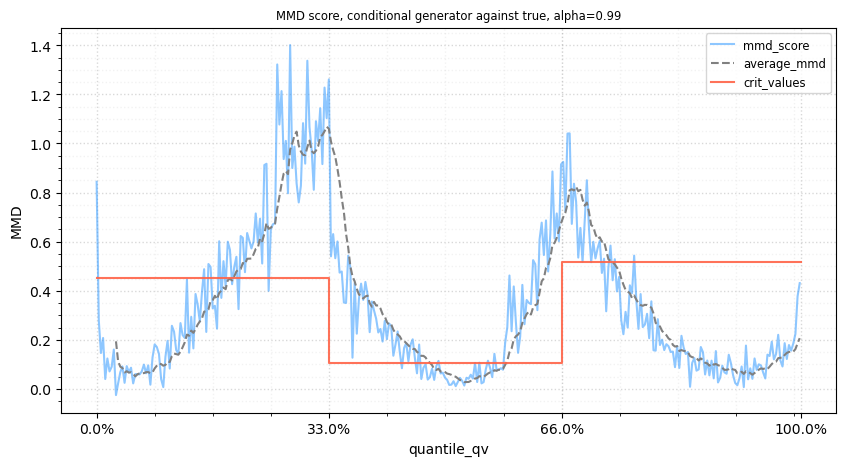

In [161]:
win_size = 10

fmt = lambda x, pos: f"{100*x/dataset_size:.1f}%"

chg_pts = [0, mask0_bds, mask1_bds, dataset_size]
cvs     = [crit_values[0]] + list(crit_values)
av_mmd  =  scores.unfold(dimension=0, size=win_size, step=1).mean(axis=1).cpu()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
make_grid(axis=ax)
ax.plot(plt_indexes, scores.cpu(), alpha=0.5, color="dodgerblue", label="mmd_score")
ax.plot(plt_indexes[win_size-1:], av_mmd, color="grey", label="average_mmd", linestyle="dashed")
ax.step(chg_pts, cvs, color="tomato", alpha=0.9, label="crit_values")
ax.set_xlabel("quantile_qv")
ax.set_ylabel("MMD")
ax.set_title(f"MMD score, conditional generator against true, alpha={alpha:.2f}", fontsize="small")
ax.xaxis.set_ticks([0, mask0_bds, mask1_bds, dataset_size])
ax.xaxis.set_major_formatter(FuncFormatter(fmt))
ax.legend(fontsize="small");